`Adapted from ng-video-lecture by Andrej Karpathy`

`Original source: https://github.com/karpathy/ng-video-lecture`

`Simplified and modified for clarity and educational use`

### Recap - Part1

We start with the data and the model (without transformer) established in last section

In [2]:
import numpy as np
import torch
import torch.nn as nn

In [3]:
############################## DATA ######################################

np.random.seed(1)

B = 4
T = 6
V = 100

# Suppose this is a batch of sequences randomly picked from the whole sequence
x = np.random.randint(0, V-1, (B, T))

x = torch.from_numpy(x)

inputs = x[:,:-1] # predictor sequences
targets = x[:,1:] # predictable sequences

In [4]:
############################  MODEL  ####################################

C = 10

class GPTLanguageModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(V, C)
        self.position_embedding_table = nn.Embedding(T-1, C)
        self.lm_head = nn.Linear(C, V)

    def forward(self, idx, targets=None):
        B, t = idx.shape
        x_tok_embed = self.token_embedding_table(idx)
        x_pos_embed = self.position_embedding_table(torch.arange(t))
        x_embed = x_tok_embed + x_pos_embed
        x_t_out = x_embed / 2 # Placeholder for Transformer Blocks
        x_raw_logits = self.lm_head(x_t_out)
        x_logits = torch.softmax(x_raw_logits, axis=2)

        if targets is None:
            loss = None
        else:
            B, t, C = x_logits.shape
            logits = x_logits.view(B*t, C)
            targets = targets.contiguous().view(B*t)
            loss = nn.functional.cross_entropy(logits, targets)
        #############################################

        return x_logits, loss

###################################################################################

# Call instance of our model class
model = GPTLanguageModel()

# Pass predictor sequence through the model
x_logits, loss = model(idx = inputs, targets = targets)

print("x_logits.shape: ", x_logits.shape)
print("\nSum of softmax logits of first token in the first sequence as probability:\n", torch.sum(x_logits[0,0,:]))
print("\nloss: ", loss)

x_logits.shape:  torch.Size([4, 5, 100])

Sum of softmax logits of first token in the first sequence as probability:
 tensor(1., grad_fn=<SumBackward0>)

loss:  tensor(4.6062, grad_fn=<NllLossBackward0>)


### Overall Model Structure

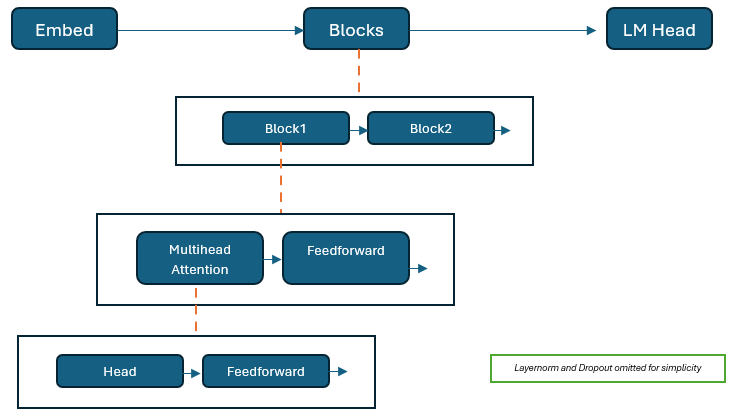

Let's first understand **Head**, rest of the stuff in the block are straightforward.

### An Attention Head

For this section, let's refer to original transformer paper 'Figure 2' 'Scaled Dot Product Attention'. 
* We create 3 linear networks `Query(x_embed)`, `Key(x_embed)` and `Value(x_embed)`.
* Then we perform matrix multiplication of `Query(x_embed)` and `Key(x_embed)` to create $(T x T)$ attention matrix.
* Each element in attention matrix represents how much attention a token should provide to other tokens.
* Note that we apply a causal mask (triangular) to make sure that each token attends to previous tokens only.
* Further, we multiply this with `Value(x_embed)` to get self-attended representation of the sequence.

This is where the tokens are talking to each other and the context is being learnt. We have entered the positional encoding earlier because the $(t \times t)$ attention matrix will be learnt corresponding to token position. In fact, using the actual token position in sentence would be better than their position in randomly chunked sequence, but it has not been done in GPT for some reason still unclear to me.

Let's take the sequence `["I", "am", "feeling", "terribly"]`. 

$$
\begin{bmatrix}
I \\
am \\
feeling \\
terribly \\
\end{bmatrix}
$$

Embedding (t x C) - 

$$
\begin{bmatrix}
0.49 & 0.31 & 0.51 & 0.55 & 0.37 & 0.23 & 0.15 & 0.83 & 0.28 & 0.79 \\
0.92 & 0.62 & 0.65 & 0.53 & 0.53 & 0.03 & 0.47 & 0.77 & 0.35 & 0.63 \\
0.73 & 0.57 & 0.91 & 0.27 & 0.24 & 0.81 & 0.12 & 0.56 & 0.36 & 0.86 \\
0.65 & 0.92 & 0.09 & 0.03 & 0.92 & 0.79 & 0.10 & 0.53 & 0.85 & 0.75 \\
\end{bmatrix}
$$

To infer the next token, when we pass this sequence through a trained attention head, it calculates (4 x 4) attention matrix based on the trained networks `Query(x_embed)` and `Key(x_embed)`.

`Query(x_embed)` x `Key(x_embed)`$^T$ (t x t) -

$$
\begin{bmatrix}
2.51 & 2.77 & 2.69 & 2.49 \\
2.77 & 3.54 & 3.06 & 2.98 \\
2.69 & 3.06 & 3.67 & 3.21 \\
2.49 & 2.98 & 3.21 & 4.34 \\
\end{bmatrix}
$$

Causal Self-Attention (t x t) before softmax -

$$
\begin{bmatrix}
2.51 & -inf & -inf & -inf \\
2.77 & 3.54 & -inf & -inf \\
2.69 & 3.06 & 3.67 & -inf \\
2.49 & 2.98 & 3.21 & 4.34 \\
\end{bmatrix}
$$

Then we apply softmax and multiply with `Value(x_embed)` ( so that -inf becomes 0 and don't contribute anything).

The output of a head is (B x t x hs), where hs stands for head_size.

In [5]:
class Head(nn.Module):

    def __init__(self, hs):
        super().__init__()

        # Query, Key and Value trio
        self.key = nn.Linear(C, hs, bias=False)
        self.query = nn.Linear(C, hs, bias=False)
        self.value = nn.Linear(C, hs, bias=False)

        # Attention mask (buffer stays in model parameter set but not trainable)
        self.register_buffer('tril', torch.tril(torch.ones(T-1, T-1)))

    def forward(self, x_embed):
        
        B,t,C = x_embed.shape
        k = self.key(x_embed)   # (B,t,hs)
        q = self.query(x_embed) # (B,t,hs)
        v = self.value(x_embed) # (B,t,hs)
        
        # Compute attention matrix (Qt' scaled by sqrt(C))
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, t, t)

        # Replace attention scores with -Inf based on attention mask
        wei = wei.masked_fill(self.tril[:t, :t] == 0, float('-inf')) # (B, t, t)

        # Softmax
        wei = nn.functional.softmax(wei, dim=-1) # (B, t, t)
        
        # Calculate self-attended representation of the B sequences
        head_out = wei @ v # (B, t, hs)
        
        return head_out

In [6]:
# Test it
head = Head(hs=5)

# Let's test it for sequences of varying length upto T-1
for t in [T-3, T-2, T-1]:
    x_embed = torch.rand(B, t, C)
    head_out = head(x_embed)
    print(head_out.shape)

torch.Size([4, 3, 5])
torch.Size([4, 4, 5])
torch.Size([4, 5, 5])


#### Discussuon: Why does it work for inferring on shorter sequence?

We are creating the attention head which is compatiable with training (T-1) length sequences and inferring next token for upto (T-1) length sequences. 

A trained self-attention matrix is of dimension (T-1) x (T-1). Each position in the self-attention matrix learns how much it should attend to previous token, previous to previous tokens and so on. If we have a shorter sequence, say t, only the corresponding upper left (t x t) corner of the matrix is used. It doesn't violate any learning.

### Multi-Head Attention

This is all about -
* computing `num_heads` heads in parallel
* concatenating the last dim (hs) from all the heads
* projecting it to C dim using a `nn.Linear()` netowrk

In [7]:
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, hs):
        super().__init__()
        self.heads = nn.ModuleList([Head(hs) for _ in range(num_heads)])
        self.proj = nn.Linear(hs * num_heads, C)

    def forward(self, x_embed):
        out = torch.cat([h(x_embed) for h in self.heads], dim=-1)
        mh_out = self.proj(out)
        return mh_out

In [8]:
# Test it
multihead = MultiHeadAttention(num_heads = 2, hs = 5)

# Let's test it for sequences of varying length upto T-1
for t in [T-3, T-2, T-1]:
    x_embed = torch.rand(B, t, C)
    mh_out = multihead(x_embed)
    print(mh_out.shape)

torch.Size([4, 3, 10])
torch.Size([4, 4, 10])
torch.Size([4, 5, 10])


### Feedforward

This is the feedforward block attached to MultiHead Attention in the image above

In [9]:
class FeedFoward(nn.Module):

    def __init__(self, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(C, 4 * C),
            nn.ReLU(),
            nn.Linear(4 * C, C)
        )

    def forward(self, mh_out):
        ff_out = self.net(mh_out)
        return ff_out

In [10]:
# Test it
ff = FeedFoward(C = 10)

# Let's test it for sequences of varying length upto T-1
for t in [T-3, T-2, T-1]:
    mh_out = torch.rand(B, t, C)
    ff_out = ff(mh_out)
    print(ff_out.shape)

torch.Size([4, 3, 10])
torch.Size([4, 4, 10])
torch.Size([4, 5, 10])


## Block

A chain of Multi-Head Attention and Feedforward

In [11]:
class Block(nn.Module):

    def __init__(self, C, num_heads):
        super().__init__()
        
        hs = C // num_heads # because in the end the heads will be concatenated to C
        self.multihead = MultiHeadAttention(num_heads, hs)
        self.ff = FeedFoward(C)

    def forward(self, x_embed):
        mh_out = x_embed + self.multihead(x_embed)
        block_out = mh_out + self.ff(mh_out)
        return block_out

In [12]:
# Test it
block = Block(C = 10, num_heads = 2)

# Let's test it for sequences of varying length upto T-1
for t in [T-3, T-2, T-1]:
    x_embed = torch.rand(B, t, C)
    block_out = block(x_embed)
    print(block_out.shape)

torch.Size([4, 3, 10])
torch.Size([4, 4, 10])
torch.Size([4, 5, 10])


### Putting it all together

We already had the generative model `GPTLanguageModel` without the `Block`s. Now that we have the blocks. Let's insert it.

In [13]:
############################## DATA ######################################

np.random.seed(1)

B = 4
T = 6
V = 100

# Suppose this is a batch of sequences randomly picked from the whole sequence
x = np.random.randint(0, V-1, (B, T))

x = torch.from_numpy(x)

inputs = x[:,:-1] # predictor sequences
targets = x[:,1:] # predictable sequences



############################  MODEL  ####################################

C = 10
num_heads = 2 # MODIFICATION : How many heads in MultiHeadAttention?
n_layer = 3 # MODIFICATION : How many blocks stacked sequentially?

class GPTLanguageModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(V, C)
        self.position_embedding_table = nn.Embedding(T-1, C)
        self.blocks = nn.Sequential(*[Block(C, num_heads) for _ in range(n_layer)])
        self.lm_head = nn.Linear(C, V)

    def forward(self, idx, targets=None):
        B, t = idx.shape
        x_tok_embed = self.token_embedding_table(idx)
        x_pos_embed = self.position_embedding_table(torch.arange(t))
        x_embed = x_tok_embed + x_pos_embed
        x_t_out = self.blocks(x_embed) # MODIFICATION : appplying the transformer blocks
        x_raw_logits = self.lm_head(x_t_out)
        x_logits = torch.softmax(x_raw_logits, axis=2)

        if targets is None:
            loss = None
        else:
            B, t, C = x_logits.shape
            logits = x_logits.view(B*t, C)
            targets = targets.contiguous().view(B*t)
            loss = nn.functional.cross_entropy(logits, targets)
        #############################################

        return x_logits, loss

###################################################################################

# Call instance of our model class
model = GPTLanguageModel()

# Pass predictor sequence through the model
x_logits, loss = model(idx = inputs, targets = targets)

print("x_logits.shape: ", x_logits.shape)
print("\nSum of softmax logits of first token in the first sequence as probability:\n", torch.sum(x_logits[0,0,:]))
print("\nloss: ", loss)

x_logits.shape:  torch.Size([4, 5, 100])

Sum of softmax logits of first token in the first sequence as probability:
 tensor(1.0000, grad_fn=<SumBackward0>)

loss:  tensor(4.6045, grad_fn=<NllLossBackward0>)


### Inference/ Generation

In [14]:
output_tokens = 10 # How many new tokens need to be generated

result = torch.randint(0,99,(4,3))
print("Input Sequence (Prompt): \n", result)

for i in range(output_tokens):

    new_inputs = result[:, -(T-1):]
    x_logits, _ = model(idx = new_inputs, targets = None)
    next_token_probability = x_logits[:,-1,:] # because we only need to generate last token
    predicted_next_token = torch.argmax(next_token_probability, axis = 1)
    result = torch.cat((result, predicted_next_token.unsqueeze(1)), dim=1)

print("\n\nHere are the sequences with {} next tokens predicted\n".format(output_tokens), 
      result)

Input Sequence (Prompt): 
 tensor([[46, 85,  6],
        [73, 71, 51],
        [82, 21,  1],
        [59, 65, 57]])


Here are the sequences with 10 next tokens predicted
 tensor([[46, 85,  6, 74, 66, 19, 12, 37, 92, 72, 72, 72, 72],
        [73, 71, 51, 15, 66, 19, 19, 19, 19, 19, 19, 19, 19],
        [82, 21,  1, 74, 66, 19, 19, 19, 19, 19, 19, 19, 19],
        [59, 65, 57, 88,  3, 72, 72, 72, 72, 72, 72, 72, 72]])
